# Завдання на використання SQL в Python

1.Встановіть бібліотеку `mysql-connector-python` через pip aбо через conda.

In [1]:
!pip install mysql-connector-python


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import mysql.connector  
from mysql.connector.connection import MySQLConnection  
import datetime

2.В змінній `con` створіть підключення до бази даних employees за аналогією того, як це робилось в лекції:

In [3]:
con = mysql.connector.connect(user = 'user1', password = '7oygWy6P', 
                              host = '3.68.62.36',
                              database = 'employees')

3.Виберіть максимальну і мінімальну дати найму співробітників використовуючи `con.cursor()`. Аби отримати результати в кінці, виконайте `cursor.fetchall()`.

In [4]:
cursor = con.cursor()  

sql = """ 
SELECT MAX(hire_date), MIN(hire_date)
FROM employees 
"""

In [5]:
cursor.execute(sql)  
cursor.fetchall()

[(datetime.date(2000, 1, 28), datetime.date(1985, 1, 1))]

Очікуваний результат:  
    `[(datetime.date(2000, 1, 28), datetime.date(1985, 1, 1))]`

4.Давайте зберемо інформацію про останню ЗП кожного співробіткника в базі. З використанням `con.cursor()` виберіть з таблиці `salaries` для кожного співробітника його номер, останню в базі даних (тобто ту, що відповідає найновішій `to_date`) ЗП, та значення `from_date`, `to_date` для цієї ЗП.

Результати запишіть у pandas DataFrame, який збережіть у змінну `res`. Як взяти з курсора назви колонок - вже наведено. На екран виведіть назви колонок в змінній `res`, розмір цього датафрейму та перші 3 записи в ньому.

УВАГА! Зверніть увагу, що ЗП може оновлюватись протягом одного дня, тобто є випадки, коли апдейт ЗП був в певний день, скажімо 2001-01-01 і потім стався ще один апдейт ЗП цьому співробітнику цього самого дня. Запит має це враховувати.
Також, теоретично ЗП може бути зменшена. Тож, брати дату з максимальною ЗП буде неправильно з точки зору бізнес логіки. Треба саме останнє історичне значення ЗП кожного співробітника.

In [18]:
cursor = con.cursor()  
last_salary = """
SELECT e.emp_no, s.salary, s.from_date, s.to_date
FROM employees as e
JOIN salaries s on e.emp_no = s.emp_no
WHERE s.to_date = (
  SELECT MAX(to_date) 
  FROM salaries 
  WHERE emp_no = e.emp_no
)
AND s.from_date = (
      SELECT MAX(from_date)
      FROM salaries
      WHERE emp_no = e.emp_no  AND to_date = s.to_date
)
"""

In [19]:
cursor.execute(last_salary)

In [20]:
field_names = [i[0] for i in cursor.description]

In [21]:
df = cursor.fetchall()

In [23]:
import pandas as pd  
res = pd.DataFrame(df, columns = field_names) 
res.shape, pd.Index(res.columns), res.head(3)

((300024, 4),
 Index(['emp_no', 'salary', 'from_date', 'to_date'], dtype='object'),
    emp_no  salary   from_date     to_date
 0   10001   88958  2002-06-22  9999-01-01
 1   10002   72527  2001-08-02  9999-01-01
 2   10003   43311  2001-12-01  9999-01-01)

Очікуваний результат:

![](https://drive.google.com/uc?export=view&id=1lNvzbAebtkj3C2v-I5AE6HkMH8MTI1kA)

5.В утвореній вибірці в змінній `res` скільки значень `to_date` рівні `9999-01-01`, а скільки - ні? Увага! Для виконання цього завдання важливо розуміти, який тип даних у значень колонки `to_date`. Зʼясуйте це, і потім напишіть фільтр для виводу потрібного результату.

In [24]:
type(res.to_date)

pandas.core.series.Series

In [33]:
count_yes = (res['to_date'] == datetime.date(9999,1,1)).sum()  
count_no =  (res['to_date'] != datetime.date(9999,1,1)).sum()  
count_yes, count_no

(np.int64(240124), np.int64(59900))

6.Виведіть візуально розподіл (гістограму) зарплат співробітників, які досі працюють в компанії, використовуючи результат попереднього завдання. Співробітниками, які досі працюють в компанії вважаємо тих, в кого to_date має значення 9999-01-01. Обовʼязково підпишіть графік і вісі.

Ці три завдання - приклад, як нам може бути зручно витягнути дані з бази певним запитом, а потім використати витягнуту вибірку у Python для подальшого аналізу.

In [34]:
import matplotlib.pyplot as plt  

In [35]:
active_emp = res[res['to_date'] == datetime.date(9999,1,1)]

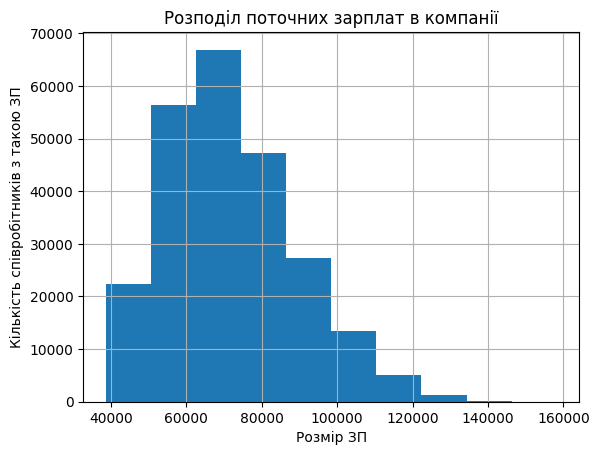

In [40]:
plt.hist(active_emp['salary'])  
plt.title('Розподіл поточних зарплат в компанії')
plt.xlabel('Розмір ЗП') 
plt.ylabel('Кількість співробітників з такою ЗП') 
plt.grid()
plt.show();

Очікуваний результат:

![](https://drive.google.com/uc?export=view&id=1j8MHLC1E0revbQLM9B0UJs6tVEgoWhmK)

НЕ ЗАБУВАЄМО ЗАКРИТИ ПІДКЛЮЧЕННЯ ДО БАЗИ :)

In [42]:
con.close()